In [1]:
import sys
import time
import statistics as ST
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import colors
from matplotlib import gridspec
#This will setup these parameter for all the figures
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
import glob
import math
import scipy.stats
import numpy as np
import statsmodels.stats.multitest as STM
import copy
import pickle
import copy
import ast
from scipy.stats import wilcoxon

## 0. function
*****

In [2]:
def all_present_total_new(input_df,cutoff_DNA,cutoff_RNA):
    temp_df=input_df[(input_df['DNA_absolute_count_S1']>=cutoff_DNA)&
                     (input_df['DNA_absolute_count_S2']>=cutoff_DNA)&
                     (input_df['DNA_absolute_count_S3']>=cutoff_DNA)&
                     (input_df['RNA_absolute_count_S1']>=cutoff_RNA)&
                     (input_df['RNA_absolute_count_S2']>=cutoff_RNA)&
                     (input_df['RNA_absolute_count_S3']>=cutoff_RNA)]
    return(temp_df)

In [3]:
def read_expression_stranded(input_name):
    temp_t=pd.read_csv(input_name,sep='\t',names=['chr','start_codon',
                                                  'end_codon','Gene','score','strand','count',
                                                  'overlap_length','window_length',
                                                  'mapped_fraction']) 
    return(temp_t)

In [4]:
def read_expression_V2(input_name):
    temp_t=pd.read_csv(input_name,sep='\t',names=['chr','start_codon',
                                                  'end_codon','Gene ID','count',
                                                  'overlap_length','window_length',
                                                  'mapped_fraction']) 
    return(temp_t)

In [5]:
def SW_annotation(input_annotation,step_size):
    temp_count = 0
    order_list = input_annotation.apply(
        lambda x: math.ceil((x['end']-x['start'])/step_size),axis=1) 
    # this is calculating how many windows for each gene
    name_list=[]
    for x,y in zip(order_list,input_annotation['gene'].tolist()):
        temp_vec = [y]*x
        name_list+=temp_vec
    return(name_list)

In [6]:
# a function to get normalized expression for intergenic region
def intergenic_expression_normalization(input_df,total_reads,window_size):
    temp = input_df.loc[input_df['window_length']==window_size,['chr','start_codon','end_codon','count','Gene','strand']]
    temp['Normalized_count_perM'] = temp['count']/total_reads*1e6
    return (temp)

In [7]:
# a fucntion to get the normalized mean expression for genic region 
def genic_expression_normalization(input_df,total_reads,window_size):
    temp_agg=input_df.loc[input_df['window_length']==window_size,['count','Gene']].groupby('Gene', as_index=False).agg({
    "count":['mean','std'],
})
    temp_agg.columns = ["_".join(x) for x in temp_agg.columns.ravel()]
    temp_agg.columns= ['Gene ID','mean_count','std_count']
    temp_agg['Normalized_count_perM'] = temp_agg['mean_count']/total_reads*1e6
    temp_agg=temp_agg.set_index('Gene ID')
    return(temp_agg)
    

In [8]:
def find_consecutive_region(input_df,value_name):
    final_chr = []
    final_start = []
    final_end = []
    final_count_N = []
    storing_count = 0
    storing_number = 0 
    for index,row in input_df.iterrows():
        if storing_number == 0:   
            storing_chr = row['chr']
            storing_start = row['start_codon']
            storing_end = row['end_codon']
            storing_count = (storing_count*storing_number+row[value_name])/(storing_number+1)
            storing_number += 1 # number of consecutive windows
        else:
            temp_chr = row['chr']
            temp_start = row['start_codon']
            temp_end = row['end_codon']
            # check if the new windows is overlapping with stored windows
            if (storing_start<temp_start<storing_end)&(temp_chr == storing_chr):
                # if yes, store the new information
                storing_chr = temp_chr
                storing_end = temp_end # I only extend end
                storing_count = (storing_count*storing_number+row[value_name])/(storing_number+1)
                storing_number += 1 # number of consecutive windows
            else:
                final_chr.append(storing_chr)
                final_start.append(storing_start)
                final_end.append(storing_end)
                final_count_N.append(storing_count)
                storing_chr = temp_chr
                storing_start = temp_start
                storing_end = temp_end 
                storing_count = row[value_name]
                storing_number = 1 
    final_chr.append(storing_chr)
    final_start.append(storing_start)
    final_end.append(storing_end)
    final_count_N.append(storing_count)
    temp_df=pd.DataFrame({'chr':final_chr,'start_codon':final_start,'end_codon':final_end,'mean_of_'+value_name:final_count_N})
    temp_df['length'] = temp_df['end_codon']-temp_df['start_codon']
    return(temp_df)

In [9]:
def find_boundary(input_row,input_df):
    # input_df should have been sorted
    # input_row is a row of a dataframe
    temp_df = input_df[input_df['Chr'] == input_row['Chr']]
    if input_row['end'] < temp_df['start'].to_list()[0]: # if before the first gene in the chromosome
        return (tuple(('NA',temp_df['gene'].to_list()[0])))
    elif input_row['start'] > temp_df['end'].to_list()[-1]: # if after the last gene in the chromosome
        return (tuple((temp_df['gene'].to_list()[-1],'NA')))
    else:
        for index,row in temp_df.iterrows():
            if row['start'] > input_row['end']:
                tt2 = row['gene']
                break
        for index,row in temp_df.sort_values(by=['Chr', 'end']).iterrows():
            if row['start'] > input_row['end']:
                tt1 = temp_store['gene']
                break
            temp_store = row
        return(tuple((tt1,tt2)))

In [10]:
def calculate_average_intergenic(input_dic,input_cb):
    dataset_name = [x for x in input_dic.keys()]
    # Generate average expression for genic expression 
    temp_sub_matrix = []
    for srr in dataset_name:
        temp_sub_matrix.append(
            input_dic[srr][input_cb]['Normalized_count_perM'].tolist())
    temp_sub_matrix = np.array(temp_sub_matrix)
    temp_E_genic_average = pd.DataFrame({'Gene ID':input_dic[srr][input_cb].index.tolist(),
                                         'Strand':input_dic[srr][input_cb]['strand'].tolist(),
                                         'Corresponding_intergenic_region':input_dic[srr][input_cb]['Gene'].tolist(),
                                    'Mean_normalized_count_perM':temp_sub_matrix.mean(axis = 0),
                                   'SD_normalized_count_perM':np.std(temp_sub_matrix,axis=0,ddof=1),
                                   'SE_normalized_count_perM':np.std(temp_sub_matrix,axis=0,ddof=1)/(temp_sub_matrix.shape[0]**0.5),'data_vector':temp_sub_matrix.transpose().tolist()})   
    return(temp_E_genic_average)

In [11]:
def calculate_average_genic(input_dic):
    dataset_name = [x for x in input_dic.keys()]
    # Generate average expression for genic expression 
    temp_sub_matrix = []
    for srr in dataset_name:
        temp_sub_matrix.append(
            input_dic[srr]['Normalized_count_perM'].tolist())
    temp_sub_matrix = np.array(temp_sub_matrix)
    temp_E_genic_average = pd.DataFrame({'Gene ID':input_dic[srr].index.tolist(),
                                    'Mean_normalized_count_perM':temp_sub_matrix.mean(axis = 0),
                                   'SD_normalized_count_perM':np.std(temp_sub_matrix,axis=0,ddof=1),
                                   'SE_normalized_count_perM':np.std(temp_sub_matrix,axis=0,ddof=1)/(temp_sub_matrix.shape[0]**0.5),'data_vector':temp_sub_matrix.transpose().tolist()})   
    return(temp_E_genic_average)

In [12]:
def comparison_function_V1(input_intergenic_dic, input_genic_dic,control_name,method,cutoff_list,input_percentile_list):
# this version will only take gene name 
# control_name is the name of control gene (for example for 50 percentile, i find a gene whose mean expression is 50 percentile then I will use this as the name of control gene)
# input_percentage is the I want to compare to what percentage of this gene
# method is specifying V1 or V2
# cutoff_list is the list of cutoff for UTR

    # number of intergenic region has significantly higher expression more than PC
    temp_PC_count_list =[]
    # number of intergenic region has significantly higher expression more than PC/ total intergenic region
    temp_PC_fraction_list = []
    # number of intergenic region has significantly higher expression more than PC (FDR)
    temp_PC_FDR_count_list =[]
    # number of intergenic region has significantly higher expression more than PC/ total intergenic region(FDR)
    temp_PC_FDR_fraction_list =[]
    
    # list of intergenic position that has higher expression than control
    temp_FDR_list = []

    # total intergenic 20bp number
    temp_total_count_list = []
    # this list stores the number of consecutive sequence
    temp_consecutive_list = []
    temp_FDR_lower_list = []
    temp_PC_FDR_count_lower_list = []
    temp_PC_FDR_fraction_lower_list = []
    
    #UTR length name
    temp_UTR_length_name = temp_UTR_length_name = np.repeat(cutoff_list, len(input_percentile_list), axis=0)
    temp_control_percentile = input_percentile_list*len(cutoff_list)
    for sub_UTR in cutoff_list:
        temp_tuple = (sub_UTR,method)
        
        
        for input_p in input_percentile_list:
            #control
            temp_control_list = []
            for srr in dataset_name:
                temp_control_list.append(
                    input_genic_dic[srr].loc[control_name]['Normalized_count_perM']*input_p)
            #data
            temp_sub_matrix = []
            for srr in dataset_name:
                temp_sub_matrix.append(
                    input_intergenic_dic[srr][temp_tuple]['Normalized_count_perM'].tolist())
            # each row is a SRR, each column is a 20 bp interval
            temp_sub_matrix=np.array(temp_sub_matrix)
            
            temp_total_count_list.append(temp_sub_matrix.shape[1])
            
            #temparory normalized expression
            # each column is data from one srr
            temp_norm_expression_matrix = temp_sub_matrix.transpose()/(temp_control_list)

            # T test to find significantly higher expression interval
            temp_total_count = input_intergenic_dic[srr][temp_tuple].shape[0]
            # pvalue list to store pvalue 
            temp_p_list = [] # compare to PC
            temp_t_list = []


            # i use normalized expression do a one sample t test, each column at a time
            temp_test = scipy.stats.ttest_1samp(temp_norm_expression_matrix.transpose(), 1) 
            temp_p_list = temp_test[1]
            temp_t_list = temp_test[0]


            #convert them to array for easiness of later calculation
            temp_p_list = np.array(temp_p_list)
            temp_t_list = np.array(temp_t_list)


            #FDR = 0.05
            temp_p_list_fdr = STM.multipletests(temp_p_list,alpha=0.05,method='fdr_bh')[1]


            # significantly larger than PC
            temp = sum((temp_p_list<0.05)*(temp_t_list>0)*1)
            temp_PC_count_list.append(temp)
            temp_PC_fraction_list.append(temp/temp_total_count)


            temp = sum((temp_p_list_fdr<0.05)*(temp_t_list>0)*1)
            ll = (temp_p_list_fdr<0.05)*(temp_t_list>0)
            temp_FDR_list.append(list(ll*1))
            if sum(ll) == 0:
                kk = np.array([])
            else:
                kk = find_consecutive_region(input_intergenic_dic[srr].get((sub_UTR,method))[ll],'Normalized_count_perM')
            temp_consecutive_list.append(kk.shape[0])


            temp_PC_FDR_count_list.append(temp)
            temp_PC_FDR_fraction_list.append(temp/temp_total_count)
            
            # sig lower than control
            temp = sum((temp_p_list_fdr<0.05)*(temp_t_list<0)*1)
            ll = (temp_p_list_fdr<0.05)*(temp_t_list<0)
            temp_FDR_lower_list.append(list(ll*1))
            temp_PC_FDR_count_lower_list.append(temp)
            temp_PC_FDR_fraction_lower_list.append(temp/temp_total_count)


    temp_output = pd.DataFrame({'UTR_length':temp_UTR_length_name,
                                'Total_number':temp_total_count_list,
                                'Control_percentile':temp_control_percentile,
                                'More_than_Control_fraction':temp_PC_fraction_list,
                                'More_than_Control_number':temp_PC_count_list,
                                'More_than_Control_FDR_fraction':temp_PC_FDR_fraction_list,
                                'More_than_Control_FDR_number':temp_PC_FDR_count_list,
                                'More_than_Control_list': temp_FDR_list,
                                'More_than_PC_consecutive':temp_consecutive_list,
                                'lower_than_Control_FDR_fraction':temp_PC_FDR_fraction_lower_list,
                                'lower_than_Control_FDR_number':temp_PC_FDR_count_lower_list,
                                'lower_than_Control_list': temp_FDR_lower_list})
    return(temp_output)

In [13]:
def calculate_paired_difference(input_df1,control_df,trait_of_interest):
    output_df = copy.deepcopy(input_df1)
    temp_name = trait_of_interest+'_difference'
    output_df[temp_name] = output_df.apply(lambda x: x[trait_of_interest]-control_df.set_index('Rep_number').loc[x['Rep_number'],trait_of_interest],axis=1)
    return(output_df)

In [14]:
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

## 1. Input and Output address
****

In [2]:
dr1='Data/'
dataset_name = ['SRR14479828', 'SRR14479829', 'SRR14479830']
sub_input_address_list = ['Expression_SW_stranded_intergenic_N'+str(x)+'_w20_s20' for x in range(1,15)]
intergenic_annotation_address_list = [dr1+'Final_bed_file/intergenic_stranded_N'+str(x) for x in range(1,15)]
# genic annotation
gene_annotation_address = dr1+'Final_bed_file/Gene_stranded_final.bed'
# genic expression
genic_input_address = dr1+ 'Expression_SW_stranded_genic_w20_s20'

In [3]:
output_address = dr1

## 2. Analysis
****

### 2.1. General information

#### 2.1.1 Total reads mapped in each replicate without considering reads mapped to the mitocondrial

In [16]:
# Total number of reads mapped to genotype for each replicate 
total_reads_list = [58681090,61416798,63529438 ]

#### 2.1.1 Intergenic region annotation

In [18]:
# intergenic annotation stored in a list 
# each item of the list contains the start and end of intergenic region 
intergenic_annotation_list = []
for count,x in enumerate(intergenic_annotation_address_list):
    temp = pd.read_csv(x, sep='\t', names=['Chr','start','end','gene'])
    intergenic_annotation_list.append(temp)

In [19]:
intergenic_annotation_list[0]

,Chr,start,end,gene
0,I,842,1614,Intergenic1
1,I,2219,2429,Intergenic2
2,I,2757,6962,Intergenic3
3,I,9241,9756,Intergenic4
4,I,10510,11262,Intergenic5
...,...,...,...,...
2748,XVI,928476,931296,Intergenic2749
2749,XVI,933404,933664,Intergenic2750
2750,XVI,936096,937918,Intergenic2751
2751,XVI,941536,942083,Intergenic2752


In [20]:
temp_length_list = [] # a list of list of length of intergenic region
for x in intergenic_annotation_list:
    temp_length = x['end'] - x['start']
    temp_length_list.append(temp_length.to_list())

##### Plotting

The mean length is 463.2116991643454
The median length is 248
There are 1077 intergenic region
The mean length is 359.0980769230769
The median length is 187.5
There are 1040 intergenic region


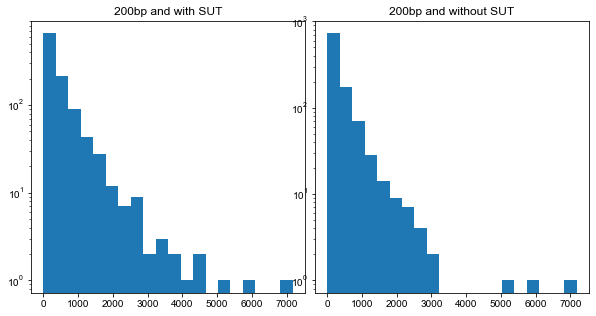

In [21]:
# (200,'V1'),(200,'V2')
gs = gridspec.GridSpec(1, 10) 
fig1 = plt.figure(figsize=(10,5))
#Here I generate sub figure object and assign to corresponding location

#panel A for SCD expression distribution
ax1=fig1.add_subplot(gs[:1, :5])
ax1.hist(temp_length_list[4],bins = 20)
ax1.set_yscale('log',base = 10)
ax1.set_title('200bp and with SUT')
print('The mean length is {}'.format(ST.mean(temp_length_list[4])))
print('The median length is {}'.format(ST.median(temp_length_list[4])))
print('There are {} intergenic region'.format(len(temp_length_list[4])))

ax2=fig1.add_subplot(gs[:1, 5:10])
ax2.hist(temp_length_list[5],bins = 20)
ax2.set_yscale('log',base = 10)
ax2.set_title('200bp and without SUT')
print('The mean length is {}'.format(ST.mean(temp_length_list[5])))
print('The median length is {}'.format(ST.median(temp_length_list[5])))
print('There are {} intergenic region'.format(len(temp_length_list[5])))

In [22]:
# I only take gene bed file without mitochondria information for genic annotation
gene_annotation = pd.read_csv(gene_annotation_address, sep='\t', names=['Chr','start','end','gene','score','strand'])

### 2.2 Combine all the data into a dictionary
<font color=red>* **I will generate a dictionary to store intergenic df and genic df**</font>

In [23]:
# intergenic dic
E_intergenic_dic = {}
# genic dic
E_genic_dic = {}
# This is the tuple key indicate the parameter for the data
tuple_key_list = [(50,'V1'),(50,'V2'),(100,'V1'),(100,'V2'),
                      (200,'V1'),(200,'V2'),(400,'V1'),(400,'V2'),
                      (800,'V1'),(800,'V2'),(1200,'V1'),(1200,'V2'),
                     (1600,'V1'),(1600,'V2')]

In [27]:
# loop over the replicate name to get both genic and intergenic expression
for count,srr in enumerate(dataset_name):
    # firt I get the intergenic expression data
    # this is part of the address for the replicate's foler name
    temp_input_address_header = dr1 + 'UTR_test/' + srr + '_expression/'
    # sub_dictionary 
    # key is a tuple ('length of UTR extension','V1/V2')
    # V1 means I don't consider SUT and ORFT
    E_intergenic_dic[srr] = {}
    # loop over the folder
    for x,y,z in zip(sub_input_address_list,
                     intergenic_annotation_list,tuple_key_list):
        temp_address = temp_input_address_header + x
        temp_intergenic = read_expression_stranded(temp_address)
        # step size is 20
        temp_intergenic = intergenic_expression_normalization(temp_intergenic,total_reads_list[count],20)
        E_intergenic_dic[srr][z] = temp_intergenic
    # Next I take care of genic expression 
    E_genic_w20_s20_temp=read_expression_stranded(dr1 + 'Analysis_' + srr + genic_input_address)
    # add gene name to genic expression
    E_genic_temp = genic_expression_normalization(E_genic_w20_s20_temp,total_reads_list[count],20)
    E_genic_dic[srr] = E_genic_temp

C:\Users\lumia\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


In [29]:
for count,srr in enumerate(dataset_name):
    temp_shared=list(set(list(E_genic_dic[srr].index))&set(list(E_genic_ST_dic[srr].index)))
    print(scipy.stats.pearsonr(x=E_genic_dic[srr].loc[temp_shared,'Normalized_count_perM'].tolist(),y=E_genic_ST_dic[srr].loc[temp_shared,'TPM'].tolist()))

(0.9638495770051752, 0.0)
(0.9649824236959136, 0.0)
(0.9636062026926535, 0.0)


##### Output

In [30]:
# store the genic expression 
pickle.dump(E_genic_dic, open(output_address+'SCD_Genic_expression_NO.p', "wb"))
pickle.dump(E_intergenic_dic, open(output_address+'SCD_Intergenic_expression_NO.p', "wb"))

##### Output boundary

In [160]:
# pickle.dump(boundary_dic, open(output_address+'Boundary_information_NO', "wb"))

In [17]:
E_genic_dic = pickle.load( open(output_address+'SCD_Genic_expression_NO.p', "rb" ) ) 
E_intergenic_dic = pickle.load( open(output_address+'SCD_Intergenic_expression_NO.p', "rb" ) )

# boundary information
boundary_dic = pickle.load( open(output_address+'Boundary_information_NO', "rb"))

# None sliding window method
# E_genic_ST_dic = pickle.load(open('C:/Users/lumia/Dropbox (University of Michigan)/1. Haiqing Xu/1. Project/China_data_directory/China_RNAseq/SCD/SCD_Genic_ST_expression.p',"rb"))

------------------

### 2.3 Mean expression binning compared to PC

<font color=Blue>* **UTR equals 200**</font>

In [20]:
control_list = []
for x in E_genic_dic.values():
    control_list.append(x.loc['YML017W']['Normalized_count_perM'])
control_list = np.array(control_list)   

In [21]:
Average_intergenic_df1 = calculate_average_intergenic(E_intergenic_dic,(200, 'V1'))

In [22]:
Average_intergenic_df2 = calculate_average_intergenic(E_intergenic_dic,(200, 'V2'))

In [37]:
Average_intergenic_df1

,Gene ID,Strand,Corresponding_intergenic_region,Mean_normalized_count_perM,SD_normalized_count_perM,SE_normalized_count_perM,data_vector
0,0,+,Intergenic1,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0]"
1,1,-,Intergenic1,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0]"
2,2,+,Intergenic1,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0]"
3,3,-,Intergenic1,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0]"
4,4,-,Intergenic1,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
48851,50877,-,Intergenic1076,0.570240,0.171028,0.098743,"[0.7668569210285631, 0.4559013317496624, 0.487..."
48852,50880,-,Intergenic1077,0.016535,0.016288,0.009404,"[0.017041264911745846, 0.0325643808392616, 0.0]"
48853,50881,+,Intergenic1077,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0]"
48854,50882,-,Intergenic1077,0.016535,0.016288,0.009404,"[0.017041264911745846, 0.0325643808392616, 0.0]"


In [38]:
# V1

In [39]:
temp_cut = np.array(list(np.linspace(0,100,11)/100))*control_list.mean()
input_df = Average_intergenic_df1
temp_total = input_df.shape[0]# total number of sequence
temp_fraction = []
output_df = copy.deepcopy(input_df[['Corresponding_intergenic_region','Strand','Mean_normalized_count_perM']])

for x in range(0,len(temp_cut)):
    if x == 10:
        temp_column_name = '>=100%' # colums name
        tt = (input_df['Mean_normalized_count_perM'] >=temp_cut[x])*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
    else:
        temp_column_name = str(x*10)+'-'+str((x+1)*10)+'%' # colums name
        tt = ((input_df['Mean_normalized_count_perM'] >=temp_cut[x])&(input_df['Mean_normalized_count_perM']<temp_cut[x+1]))*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
DF_fraction = pd.DataFrame({'bins':np.linspace(0,100,11)/100,'Fraction':temp_fraction})

##### Output

In [40]:
DF_fraction.to_csv(output_address+'SCD_PC_average_fraction_10_V1_NO.csv')
output_df.to_csv(output_address+'SCD_PC_average_fraction_10_V1_details_NO.csv')

In [41]:
#V2

In [42]:
temp_cut = np.array(list(np.linspace(0,100,11)/100))*control_list.mean()
input_df = Average_intergenic_df2
temp_total = input_df.shape[0]# total number of sequence
temp_fraction = []
output_df = copy.deepcopy(input_df[['Corresponding_intergenic_region','Strand','Mean_normalized_count_perM']])

for x in range(0,len(temp_cut)):
    if x == 10:
        temp_column_name = '>=100%' # colums name
        tt = (input_df['Mean_normalized_count_perM'] >=temp_cut[x])*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
    else:
        temp_column_name = str(x*10)+'-'+str((x+1)*10)+'%' # colums name
        tt = ((input_df['Mean_normalized_count_perM'] >=temp_cut[x])&(input_df['Mean_normalized_count_perM']<temp_cut[x+1]))*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
DF_fraction = pd.DataFrame({'bins':np.linspace(0,100,11)/100,'Fraction':temp_fraction})

##### Output

In [43]:
DF_fraction.to_csv(output_address+'SCD_PC_average_fraction_10_V2_NO.csv')
output_df.to_csv(output_address+'SCD_PC_average_fraction_10_V2_details_NO.csv')

In [38]:
# V1

In [27]:
temp_cut = np.array(list(np.linspace(0,100,21)/100))*control_list.mean()
input_df = Average_intergenic_df1
temp_total = input_df.shape[0]# total number of sequence
temp_fraction = []
output_df = copy.deepcopy(input_df[['Corresponding_intergenic_region','Strand','Mean_normalized_count_perM']])

for x in range(0,len(temp_cut)):
    if x == 20:
        temp_column_name = '>=100%' # colums name
        tt = (input_df['Mean_normalized_count_perM'] >=temp_cut[x])*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
    else:
        temp_column_name = str(x*5)+'-'+str((x+1)*5)+'%' # colums name
        tt = ((input_df['Mean_normalized_count_perM'] >=temp_cut[x])&(input_df['Mean_normalized_count_perM']<temp_cut[x+1]))*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
DF_fraction = pd.DataFrame({'bins':np.linspace(0,100,21)/100,'Fraction':temp_fraction})

##### Output

In [28]:
DF_fraction.to_csv(output_address+'SCD_PC_average_fraction_20_V1_NO.csv')
output_df.to_csv(output_address+'SCD_PC_average_fraction_20_V1_details_NO.csv')

In [29]:
#V2

In [30]:
temp_cut = np.array(list(np.linspace(0,100,21)/100))*control_list.mean()
input_df = Average_intergenic_df2
temp_total = input_df.shape[0]# total number of sequence
temp_fraction = []
output_df = copy.deepcopy(input_df[['Corresponding_intergenic_region','Strand','Mean_normalized_count_perM']])

for x in range(0,len(temp_cut)):
    if x == 20:
        temp_column_name = '>=100%' # colums name
        tt = (input_df['Mean_normalized_count_perM'] >=temp_cut[x])*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
    else:
        temp_column_name = str(x*5)+'-'+str((x+1)*5)+'%' # colums name
        tt = ((input_df['Mean_normalized_count_perM'] >=temp_cut[x])&(input_df['Mean_normalized_count_perM']<temp_cut[x+1]))*1
        output_df[temp_column_name] = tt
        temp_fraction.append(sum(tt)/temp_total)
DF_fraction = pd.DataFrame({'bins':np.linspace(0,100,21)/100,'Fraction':temp_fraction})

##### Output

In [31]:
DF_fraction.to_csv(output_address+'SCD_PC_average_fraction_20_V2_NO.csv')
output_df.to_csv(output_address+'SCD_PC_average_fraction_20_V2_details_NO.csv')

------

### 2.5 Analysis by T test to different percentage of PC control

#### 2.5.1 compare to NC

In [32]:
PC_comparison_nc_V1 = comparison_function_V1(E_intergenic_dic, E_genic_dic,'YML017W','V1',[50,100,200,400,800,1200,1600],[1/22.2])

In [33]:
PC_comparison_nc_V2 = comparison_function_V1(E_intergenic_dic, E_genic_dic,'YML017W','V1',[50,100,200,400,800,1200,1600],[1/22.2])

In [34]:
PC_comparison_nc_V1.to_csv(output_address +'SCD_PC_NC_comparison_V1_NO',index=False)
PC_comparison_nc_V2.to_csv(output_address +'SCD_PC_NC_comparison_V2_NO',index=False)

#### 2.5.1 compare to PC

##### 2.5.1.1. V1

In [73]:
PC_comparison_new_V1 = comparison_function_V1(E_intergenic_dic, E_genic_dic,'YML017W','V1',[50,100,200,400,800,1200,1600],list(np.linspace(1,10,10)/10))

##### 2.5.1.2. V2

In [74]:
PC_comparison_new_V2 = comparison_function_V1(E_intergenic_dic, E_genic_dic,'YML017W','V2',[50,100,200,400,800,1200,1600],list(np.linspace(1,10,10)/10))

##### Output

In [75]:
PC_comparison_new_V1.to_csv(output_address +'SCD_PC_percentile_comparison_V1_NO',index=False)
PC_comparison_new_V2.to_csv(output_address +'SCD_PC_percentile_comparison_V2_NO',index=False)

##### Plotting

In [76]:
PC_comparison_new_V1[PC_comparison_new_V1['UTR_length']==200]

,UTR_length,Total_number,Control_percentile,More_than_Control_fraction,More_than_Control_number,More_than_Control_FDR_fraction,More_than_Control_FDR_number,More_than_Control_list,More_than_PC_consecutive,lower_than_Control_FDR_fraction,lower_than_Control_FDR_number,lower_than_Control_list
20,200,48856,0.1,0.270059,13194,0.226318,11057,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11057,0.382553,18690,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
21,200,48856,0.2,0.157053,7673,0.143094,6991,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6991,0.594216,29031,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
22,200,48856,0.3,0.102730,5019,0.097184,4748,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4748,0.721058,35228,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
23,200,48856,0.4,0.072683,3551,0.069592,3400,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3400,0.804650,39312,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24,200,48856,0.5,0.053914,2634,0.052256,2553,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2553,0.857459,41892,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
25,200,48856,0.6,0.040466,1977,0.039729,1941,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1941,0.892480,43603,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
26,200,48856,0.7,0.032872,1606,0.032565,1591,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1591,0.916817,44792,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
27,200,48856,0.8,0.027223,1330,0.026854,1312,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1312,0.932925,45579,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
28,200,48856,0.9,0.022863,1117,0.022761,1112,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1112,0.945923,46214,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
29,200,48856,1.0,0.019568,956,0.019445,950,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",950,0.955174,46666,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


Text(0.5, 0.07, 'UTR extension length (bp)')

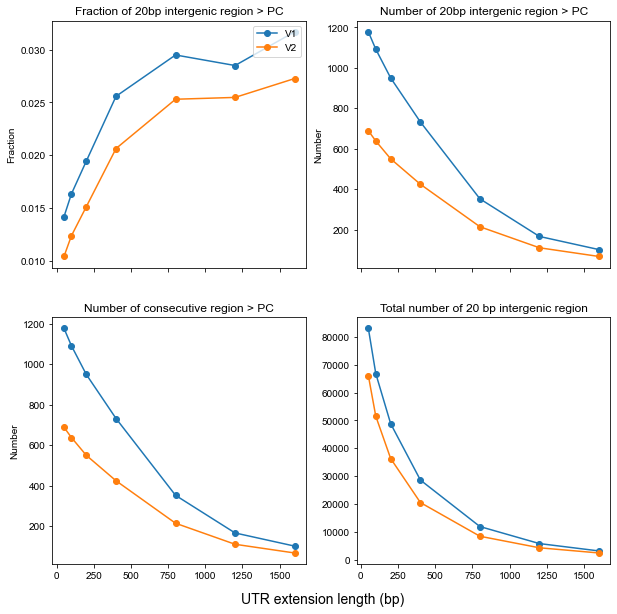

In [77]:
fig1,ax = plt.subplots(2, 2, figsize=(10,10),sharex=True)
axes = ax.flatten()
temp_input_percentile = 1
temp_input_df_V1 = PC_comparison_new_V1[PC_comparison_new_V1['Control_percentile']==temp_input_percentile]
temp_input_df_V2 = PC_comparison_new_V2[PC_comparison_new_V2['Control_percentile']==temp_input_percentile]
axes[0].plot(temp_input_df_V1['UTR_length'], temp_input_df_V1['More_than_Control_FDR_fraction'],  '-o',label = 'V1')
axes[0].plot(temp_input_df_V2['UTR_length'], temp_input_df_V2['More_than_Control_FDR_fraction'],  '-o',label = 'V2')
axes[0].set_title('Fraction of 20bp intergenic region > PC')
axes[0].set_ylabel('Fraction')
axes[0].legend(loc='upper right')

axes[1].plot(temp_input_df_V1['UTR_length'], temp_input_df_V1['More_than_Control_FDR_number'],  '-o')
axes[1].plot(temp_input_df_V2['UTR_length'], temp_input_df_V2['More_than_Control_FDR_number'],  '-o')
axes[1].set_title('Number of 20bp intergenic region > PC')
axes[1].set_ylabel('Number')

axes[2].plot(temp_input_df_V1['UTR_length'], temp_input_df_V1['More_than_PC_consecutive'],  '-o')
axes[2].plot(temp_input_df_V2['UTR_length'], temp_input_df_V2['More_than_PC_consecutive'],  '-o')
axes[2].set_ylabel('Number')
axes[2].set_title('Number of consecutive region > PC')

axes[3].plot(temp_input_df_V1['UTR_length'], temp_input_df_V1['Total_number'],  '-o')
axes[3].plot(temp_input_df_V2['UTR_length'], temp_input_df_V2['Total_number'],  '-o')
axes[3].set_title('Total number of 20 bp intergenic region')
# fig1.text(0.08, 0.5, 'UTR extension length (bp)', va='center', rotation='vertical',fontsize=20)
fig1.text(0.5, 0.07, 'UTR extension length (bp)', ha='center',fontsize=14)